# Training for model revenue prediction



### Imports and environment setup

In [ ]:
colab_run = True

if colab_run :
  from google.colab import drive
  import os.path as osp
  import sys
  import torch
  drive_check = osp.ismount("/content/drive")
  # check if already mounted
  if not drive_check:
      drive.mount('/content/drive')

  sys.path.insert(1, '/content/drive/MyDrive/Scalable Project')

%load_ext autoreload
%autoreload 2

!pip install hopsworks

import hopsworks

import utils
import pandas as pd

import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import numpy as np

import joblib

scaling_factor = 1000000


### Data from hopsworks

In [2]:
project = hopsworks.login(api_key_value=utils.get_api_key())
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/359572
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
movie_fg = fs.get_feature_group(name="movies", version=1)
query = movie_fg.select_all()

feature_view = fs.get_or_create_feature_view(name="movies",
                                  version=1,
                                  description="Get movies in the dataset",
                                  labels=["revenue"],
                                  query=query)

In [4]:
data = feature_view.train_validation_test_split(validation_size = 0.1, test_size = 0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.31s) 


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = data

### Training a basic K-Neighbours Regressor

In [11]:
X_train_scaled = X_train[['top_cast_popularity', 'budget', 'crew_popularity', 'similar_revenues']]
X_test_scaled = X_test[['top_cast_popularity', 'budget', 'crew_popularity', 'similar_revenues']]
X_val_scaled = X_val[['top_cast_popularity', 'budget', 'crew_popularity', 'similar_revenues']]

X_train_scaled[['budget', 'similar_revenues']] = X_train[['budget', 'similar_revenues']]/scaling_factor
y_train_scaled = y_train[['revenue']]/scaling_factor
X_val_scaled[['budget', 'similar_revenues']] = X_val[['budget', 'similar_revenues']]/scaling_factor
y_val_scaled = y_val[['revenue']]/scaling_factor
X_test_scaled[['budget', 'similar_revenues']] = X_test[['budget', 'similar_revenues']]/scaling_factor
y_test_scaled = y_test[['revenue']]/scaling_factor


n_min = 1
n_max = 20
r2s = np.zeros((len(range(n_min,n_max)), 3))
mses = np.zeros((len(range(n_min,n_max)), 3))


for n_neighbours in range(n_min,n_max):
  model = KNeighborsRegressor(n_neighbors=n_neighbours)
  reg = model.fit(X_train_scaled, y_train_scaled)

  print("--------------------------------------------------------------------------")
  # Evaluate on training set
  y_pred = reg.predict(X_train_scaled)
  mse = mean_squared_error(y_train_scaled, y_pred)
  mae = mean_absolute_error(y_train_scaled, y_pred)
  r2 = r2_score(y_train_scaled, y_pred)
  print("Training set scores for %d neighbours:\t mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))
  r2s[n_neighbours - n_min, 0] = r2
  mses[n_neighbours - n_min, 0] = mse


  # Evaluate on test set
  y_pred = reg.predict(X_val_scaled)
  y_pred = np.nan_to_num(y_pred)
  mse = mean_squared_error(y_val_scaled, y_pred)
  mae = mean_absolute_error(y_val_scaled, y_pred)
  r2 = r2_score(y_val_scaled, y_pred)
  print("Validation set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))
  r2s[n_neighbours - n_min, 1] = r2
  mses[n_neighbours - n_min, 1] = mse

  # Evaluate on test set
  y_pred = reg.predict(X_test_scaled)
  y_pred = np.nan_to_num(y_pred)
  mse = mean_squared_error(y_test_scaled, y_pred)
  mae = mean_absolute_error(y_test_scaled, y_pred)
  r2 = r2_score(y_test_scaled, y_pred)
  print("Test set scores for %d neighbours:\t mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))
  r2s[n_neighbours - n_min,2] = r2
  mses[n_neighbours - n_min, 2] = mse



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------------------------------------
Training set scores for 1 neighbours:	 mse 7.754021, mae 0.078070, r2 0.999744
Validation set scores for 1 neighbours: mse 13013.654991, mae 52.243499, r2 0.640077
Test set scores for 1 neighbours:	 mse 19570.698418, mae 57.336106, r2 0.260580
--------------------------------------------------------------------------
Training set scores for 2 neighbours:	 mse 5366.434024, mae 29.173985, r2 0.822761
Validation set scores for 2 neighbours: mse 13221.673859, mae 49.927176, r2 0.634324
Test set scores for 2 neighbours:	 mse 15744.576362, mae 53.523931, r2 0.405139
--------------------------------------------------------------------------
Training set scores for 3 neighbours:	 mse 7596.758242, mae 36.054487, r2 0.749099
Validation set scores for 3 neighbours: mse 14854.464608, mae 49.691859, r2 0.589166
Test set scores for 3 neighbours:	 mse 14293.059147, mae 51.587531, r2 0.459980
-----------------------------------

### Plot the values of metrics depending on the number of neighbours

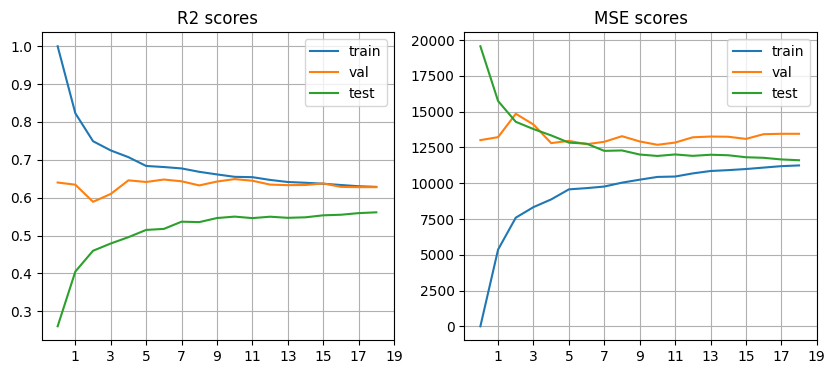

In [12]:
f, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot( r2s)
ax[0].legend(['train', 'val', 'test'])
ax[0].set_xticks(range(n_min, n_max, 2))
ax[0].grid()
ax[0].set_title("R2 scores")
ax[1].plot(mses)
ax[1].legend(['train', 'val', 'test'])
ax[1].set_xticks(range(n_min, n_max, 2))
ax[1].set_title("MSE scores")
ax[1].grid()


Based on the plots we chose to train a model with 7 neighbours.

In [28]:
n_neighbours = 7
model = KNeighborsRegressor(n_neighbors=n_neighbours)
reg = model.fit(X_train_scaled, y_train_scaled)

# Evaluate on training set
y_pred = reg.predict(X_train_scaled)
mse = mean_squared_error(y_train_scaled, y_pred)
mae = mean_absolute_error(y_train_scaled, y_pred)
r2 = r2_score(y_train_scaled, y_pred)
print("Training set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))

  # Evaluate on test set
y_pred = reg.predict(X_val_scaled)
y_pred = np.nan_to_num(y_pred)
mse = mean_squared_error(y_val_scaled, y_pred)
mae = mean_absolute_error(y_val_scaled, y_pred)
r2 = r2_score(y_val_scaled, y_pred)
print("Validation set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))

  # Evaluate on test set
y_pred = reg.predict(X_test_scaled)
y_pred = np.nan_to_num(y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)
print("Test set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))


Training set scores for 7 neighbours: mse 9659.841304, mae 40.998087, r2 0.680961
Validation set scores for 7 neighbours: mse 12728.800263, mae 46.948055, r2 0.647956
Test set scores for 7 neighbours: mse 12766.969758, mae 47.915948, r2 0.517639


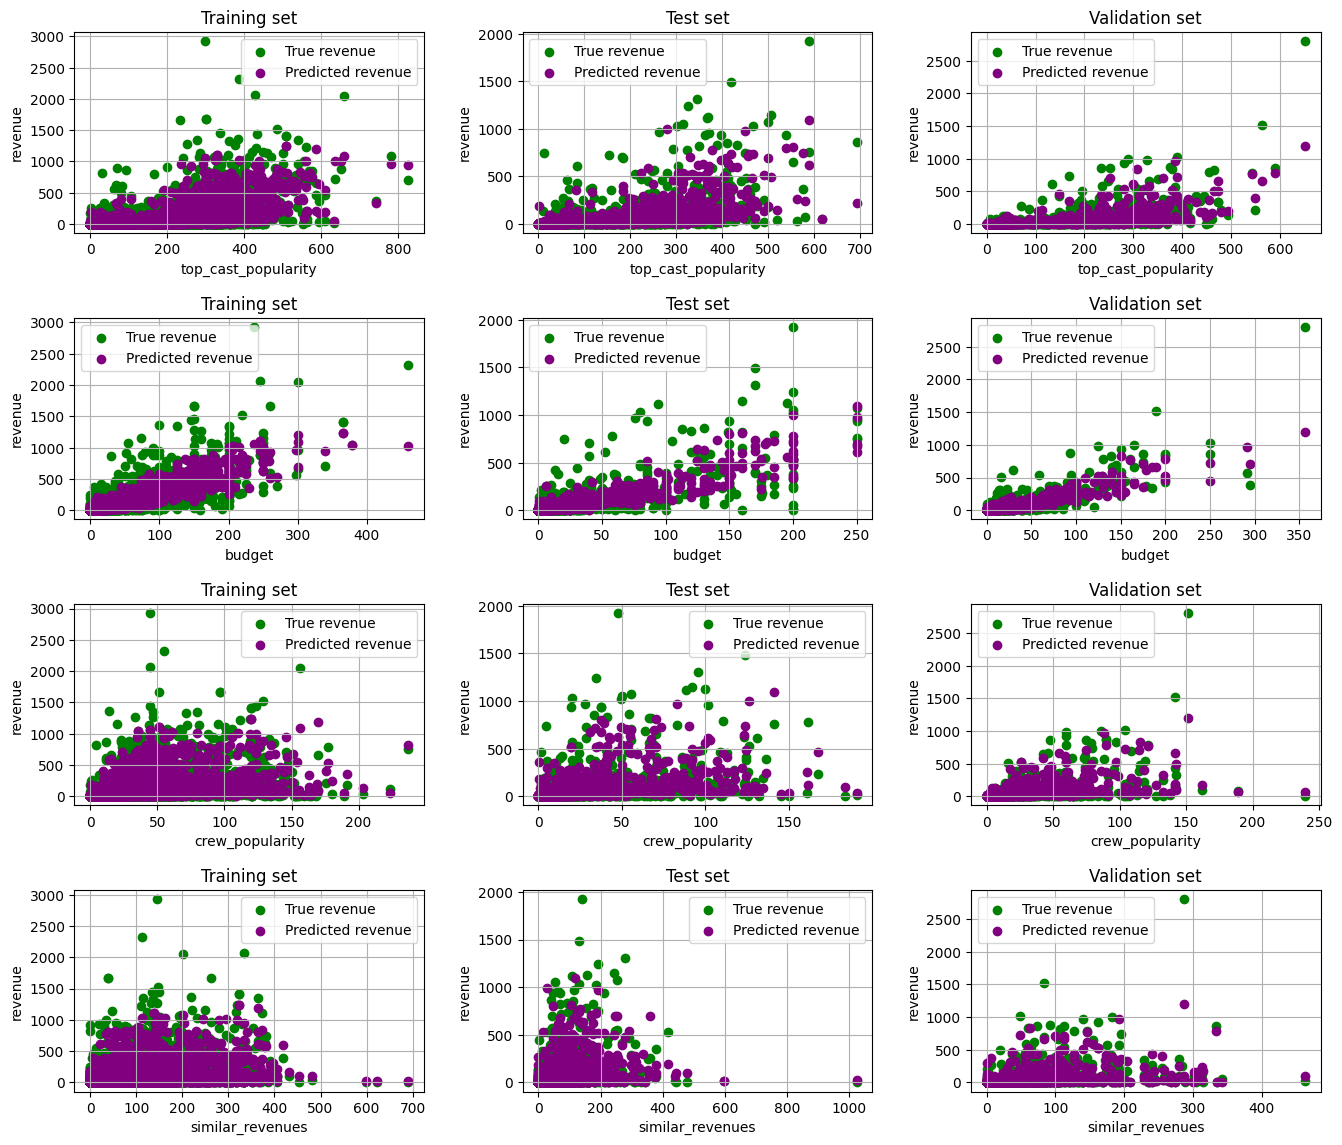

In [29]:
features = ['top_cast_popularity', 'budget', 'crew_popularity', 'similar_revenues']
f, ax = plt.subplots(len(features), 3,figsize=(14, 3*len(features)))
f.tight_layout(pad = 4)
for i, feature in enumerate(features):
  ax[i,0].scatter(X_train_scaled[feature], y_train_scaled, color='green')
  ax[i,0].scatter(X_train_scaled[feature], reg.predict(X_train_scaled), color='purple')
  ax[i,0].set_title('Training set')
  ax[i,0].set_xlabel(feature)
  ax[i,0].set_ylabel('revenue')
  ax[i,0].legend(['True revenue', 'Predicted revenue'])
  ax[i,0].grid()
  ax[i,1].scatter(X_test_scaled[feature], y_test_scaled, color='green')
  ax[i,1].scatter(X_test_scaled[feature], reg.predict(X_test_scaled), color='purple')
  ax[i,1].set_title('Test set')
  ax[i,1].set_xlabel(feature)
  ax[i,1].set_ylabel('revenue')
  ax[i,1].legend(['True revenue', 'Predicted revenue'])
  ax[i,1].grid()
  ax[i,2].scatter(X_val_scaled[feature], y_val_scaled, color='green')
  ax[i,2].scatter(X_val_scaled[feature], reg.predict(X_val_scaled), color='purple')
  ax[i,2].set_title('Validation set')
  ax[i,2].set_xlabel(feature)
  ax[i,2].set_ylabel('revenue')
  ax[i,2].legend(['True revenue', 'Predicted revenue'])
  ax[i,2].grid()

plt.show()

### Upload model to hopsworks

In [30]:
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os

In [31]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="movies_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + f"/k-neighbours{n_neighbours}.pkl")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train_scaled)
output_schema = Schema(y_train_scaled)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
movie_model = mr.python.create_model(
    name=f"movie_kn{n_neighbours}",
    metrics={"r2" : r2},
    model_schema=model_schema,
    description="Movie revenue predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
movie_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/438950 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/438950 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/491 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/359572/models/movie_kn7/1


Model(name: 'movie_kn7', version: 1)

## Training NNs

In [ ]:
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MoviesDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.movies_frame = pd.read_csv(csv_file)
        self.movies_frame.fillna(0)
        self.movies_frame = self.movies_frame[self.movies_frame['vote_count'] > 0]
        self.transform = transform

    def __len__(self):
      return len(self.movies_frame)

    def __getitem__(self, idx, features = ['top_cast_popularity', 'budget', 'crew_popularity', 'similar_revenues']):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      sample = self.movies_frame[features + ['revenue']].iloc[idx,:]
      if self.transform:
        sample = self.transform(sample)


      return np.array(sample[features], dtype = float), np.array(sample[['revenue']], dtype = float)


In [ ]:
class ScaleTransform():
  def __init__(self, scaling_factor, indexes = [1,3]):
    self.scaling_factor = scaling_factor
    self.indexes = indexes

  def __call__(self, input_array):
    for i in self.indexes:
      input_array[i] /= self.scaling_factor
    return input_array


In [ ]:
movie_dataset = MoviesDataset(csv_file = '/content/drive/MyDrive/Scalable Project/movies1-100.csv', transform = ScaleTransform(scaling_factor=100000))

In [ ]:
movie_dataset.movies_frame.iloc[0,:]

adult                                                                False
backdrop_path                             /vL5LR6WdxWPjLPFRLe133jXWsh5.jpg
belongs_to_collection    {'id': 87096, 'name': 'Avatar Collection', 'po...
budget                                                           237000000
genres                   [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
homepage                              https://www.avatar.com/movies/avatar
id                                                                   19995
imdb_id                                                          tt0499549
original_language                                                       en
original_title                                                      Avatar
overview                 In the 22nd century, a paraplegic Marine is di...
popularity                                                         130.762
poster_path                               /kyeqWdyUXW608qlYkRqosgbbJyK.jpg
production_companies     

In [ ]:
movie_dataset.__getitem__(0)

(array([ 296.728     , 2370.        ,   39.879     ,  154.55790167]),
 array([2.92370603e+09]))

In [ ]:
data_loader = DataLoader(movie_dataset, 8, shuffle = True)

In [ ]:
class RevenuePredictor(nn.Module):
  def __init__(self, input_dim, output_dim) :
    super(RevenuePredictor, self).__init__()
    self.input_layer = nn.Linear(in_features= input_dim, out_features=128)
    self.hidden_layer1 = nn.Linear(in_features = 128, out_features=256)
    self.hidden_layer2 = nn.Linear(in_features = 256, out_features=128)
    self.output_layer = nn.Linear(in_features=128, out_features=1)
    self.activation = nn.ReLU()
    self.float()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.activation(x)
    x = self.hidden_layer1(x)
    x = self.activation(x)
    x = self.hidden_layer2(x)
    x = self.activation(x)
    y = self.output_layer(x)
    return y

In [ ]:
network = RevenuePredictor(4, 1)
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3)
losses = []
network.train()
for epoch in range(5):
  for i, batch in enumerate(data_loader):
    X, y = batch
    X = X.float()
    y = y.float()
    network.zero_grad()
    y_pred = network(X)
    loss = F.mse_loss(y_pred, y)
    loss.backward()
    optimizer.step()
    # print(f"Loss was {loss}")
    losses.append(loss.detach())

<ipython-input-196-c8a831300fde>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_array[i] /= self.scaling_factor


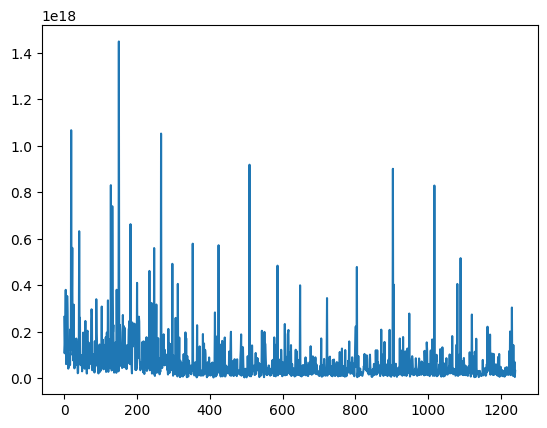

In [ ]:
plt.plot(losses)

In [ ]:
plot_loader = DataLoader(movie_dataset, 512, shuffle = False)
for i, batch in enumerate(plot_loader):
  x_plot, y_plot = batch
  x_plot = x_plot.float()
  y_plot = y_plot.float()
  break
network.eval()
with torch.no_grad():
  y_plot_preds = network(x_plot)

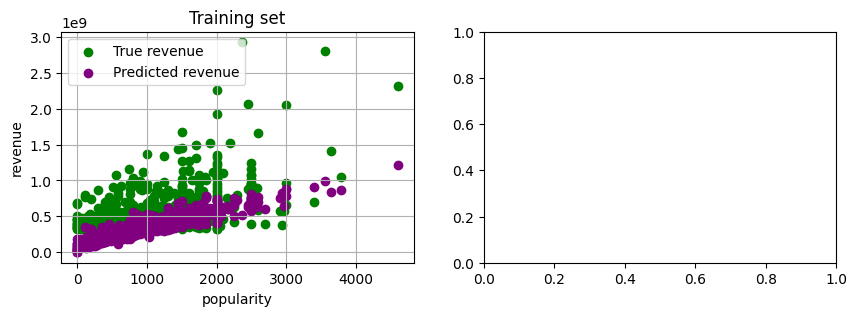

In [ ]:
f, ax = plt.subplots(1, 2,figsize=(10, 3))
ax[0].scatter(x_plot[:,1], y_plot, color='green')
ax[0].scatter(x_plot[:,1], y_plot_preds.detach(), color = 'purple')
ax[0].set_title('Training set')
ax[0].set_xlabel('popularity')
ax[0].set_ylabel('revenue')
ax[0].legend(['True revenue', 'Predicted revenue'])
ax[0].grid()
# ax[1].scatter(X_test['top_cast_popularity'], y_test, color='green')
# ax[1].scatter(X_test['top_cast_popularity'], reg.predict(X_test), color='purple')
# ax[1].set_title('Test set')
# ax[1].set_xlabel('popularity')
# ax[1].set_ylabel('revenue')
# ax[1].legend(['True revenue', 'Predicted revenue'])
# ax[1].grid()

plt.show()

# plt.scatter(X_train, y_train, color='green')
# plt.scatter(X_train, reg.predict(X_train), color='purple')